In [4]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA
from collections import Counter

import sys
from pathlib import Path
scripts_dir = Path().resolve()

function_dir = scripts_dir.parent
sys.path.insert(0, str(function_dir))
import Functions.mouse as mouse
from SSM.ssm.plots import gradient_cmap

parent_dir = scripts_dir.parent.parent/'aeon_mecha'
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
from aeon.schema.schemas import social02

LABELS = [
    ['Pre','BAA-1104045'],
    ['Pre','BAA-1104047'],
    ['Post','BAA-1104045'],
    ['Post','BAA-1104047']
]
nodes_name = ['nose', 'head', 'right_ear', 'left_ear', 'spine1', 'spine2','spine3', 'spine4']
color_names = ['black', "blue", "red", "tan", "green", "brown", "purple", "orange", 'turquoise', "yellow", 'pink', 'darkblue']

In [2]:
def calculate_count_curve(states, target_state, window_size):
    count_curve = np.zeros(len(states))
    for i in range(len(states) - window_size + 1):
        window = states[i:i+window_size]
        count = np.count_nonzero(window == target_state)
        count_curve[i] = count/window_size

    return count_curve


def calculate_probability_curve(exploring, clining, digging, time_shift_exploring = 25, time_shift_cining = 5):
    p = np.zeros(len(exploring))
    
    x_mean = 1
    x_std = 0.5

    y_mean = 1
    y_std = 0.5
    
    z_mean = 1
    z_std = 0.6
    
    for t in range(time_shift_exploring, len(p)):
        p[t] = np.exp(-((exploring[t-time_shift_exploring] - x_mean) ** 2) / (2 * x_std ** 2)) * np.exp(-((clining[t-time_shift_cining] - y_mean) ** 2) / (2 * y_std ** 2)) * np.exp(-((digging[t] - z_mean) ** 2) / (2 * z_std ** 2)) 

    return p


In [2]:
Mouse = mouse.Mouse(aeon_exp='AEON3', type = 'Pre', mouse = 'BAA-1104047')
Mouse.arena.entry

DatetimeIndex(['2024-02-05 15:45:46.780000', '2024-02-05 15:50:20.180000',
               '2024-02-05 15:59:59.680000', '2024-02-05 16:02:41.880000',
               '2024-02-05 16:08:18.380000', '2024-02-05 16:08:51.880000',
               '2024-02-05 16:09:06.780000', '2024-02-05 16:14:23.280000',
               '2024-02-05 16:18:11.780000', '2024-02-05 16:20:57.780000',
               ...
               '2024-02-08 14:11:56.080000', '2024-02-08 14:12:17.680000',
               '2024-02-08 14:12:26.680000', '2024-02-08 14:12:35.780000',
               '2024-02-08 14:13:15.180000', '2024-02-08 14:13:38.180000',
               '2024-02-08 14:16:16.280000', '2024-02-08 14:16:35.680000',
               '2024-02-08 14:17:50.280000', '2024-02-08 14:47:40.780000'],
              dtype='datetime64[ns]', length=386, freq=None)

In [14]:
start, end = pd.Timestamp("2024-02-05 15:45:46.780000"), pd.Timestamp("2024-02-05 15:45:46.880000")
root = '/ceph/aeon/aeon/data/raw/AEON3/social0.2/'
video_metadata = aeon.load(root, social02.CameraTop.Video, start=start, end=end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
first_frame = next(frames)
cv2.imwrite("first_frame.jpg", first_frame)

True

In [13]:
x = np.array([1,2,3,4,5], [1,2,3,4,5])
y = np.array([2,3,4,5,6])
z = np.concatenate(x,y)
z

TypeError: Field elements must be 2- or 3-tuples, got '1'

In [4]:
Mouse = mouse.Mouse(aeon_exp='AEON3', type = 'Pre', mouse = 'BAA-1104047')

Mouse.hmm.n_state = 12
Mouse.hmm.feature = 'Kinematics_and_Body'
Mouse.hmm.Get_Features()
Mouse.hmm.Get_States()
Mouse.arena.Get_Pellets()
Mouse.arena.Get_Visits()

mouse_pos = Mouse.mouse_pos
states = Mouse.hmm.states
N = Mouse.hmm.n_state
Pellets = Mouse.arena.pellets
Visits = Mouse.arena.visits

mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)
Visits = Visits.dropna(subset=['speed'])

exploring = calculate_count_curve(states, target_state = 11, window_size = 3)
clining = calculate_count_curve(states, target_state = 7, window_size = 3)
digging = calculate_count_curve(states, target_state = 5, window_size = 3)


probability_curve = calculate_probability_curve(exploring, clining, digging, time_shift_exploring = 20, time_shift_cining = 2)
mouse_pos.loc[mouse_pos.index, 'enter_prob'] = probability_curve

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
T = np.arange(-50, 50, 1)
ENTRY_PROB= []
for i in range(len(Visits)):
    trigger = Visits.iloc[i]['start']
    if trigger > mouse_pos.index[-1]: break
    
    latest_valid_index = mouse_pos.loc[trigger - pd.Timedelta('6S'):trigger, 'enter_prob'].index
    latest_valid_state = mouse_pos.loc[latest_valid_index, ['enter_prob']].values.reshape(-1)
    if len(latest_valid_state) >= 50: latest_valid_state  = latest_valid_state[-50:]
    
    next_valid_index = mouse_pos.loc[trigger:trigger + pd.Timedelta('6S'), 'enter_prob'].index
    next_valid_state = mouse_pos.loc[next_valid_index, ['enter_prob']].values.reshape(-1)
    if len(next_valid_state) >= 50: next_valid_state  = next_valid_state[:50]
    
    enter_prob = np.concatenate((latest_valid_state, next_valid_state))
    
    if len(enter_prob) == 100: 
        axs.plot(T, enter_prob, color = 'grey', alpha = 0.5)
        ENTRY_PROB.append(enter_prob)

axs.plot(T, np.mean(np.array(ENTRY_PROB), axis = 0), color = 'black')
axs.axvline(x = 0, color = 'red')
plt.show()

: 

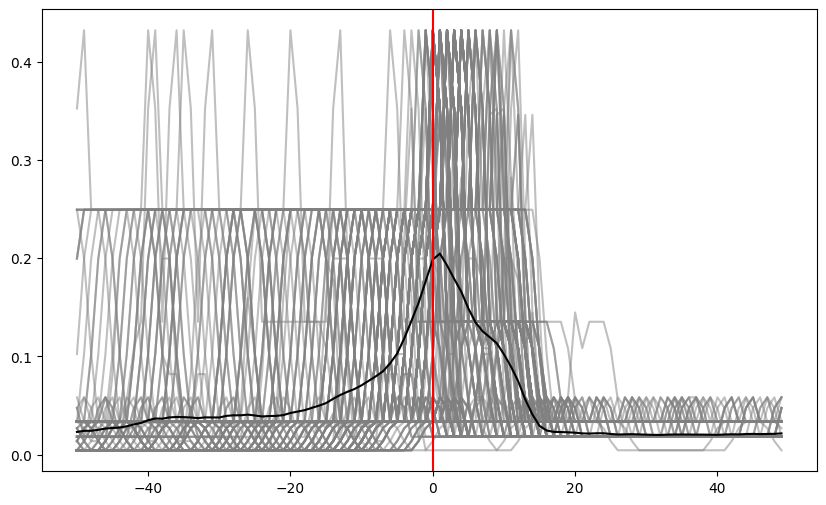

In [3]:
Mouse = mouse.Mouse(aeon_exp='AEON3', type = 'Post', mouse = 'BAA-1104047')

Mouse.hmm.n_state = 12
Mouse.hmm.feature = 'Kinematics_and_Body'
Mouse.hmm.Get_Features()
Mouse.hmm.Get_States()
Mouse.arena.Get_Pellets()
Mouse.arena.Get_Visits()

mouse_pos = Mouse.mouse_pos
states = Mouse.hmm.states
N = Mouse.hmm.n_state
Pellets = Mouse.arena.pellets
Visits = Mouse.arena.visits

mouse_pos['state'] = pd.Series(states, index = mouse_pos.index)
Visits = Visits.dropna(subset=['speed'])

exploring = calculate_count_curve(states, target_state = 11, window_size = 3)
clining = calculate_count_curve(states, target_state = 6, window_size = 3)
digging = calculate_count_curve(states, target_state = 2, window_size = 3)


probability_curve = calculate_probability_curve(exploring, clining, digging, time_shift_exploring = 15, time_shift_cining = 0)
mouse_pos.loc[mouse_pos.index, 'enter_prob'] = probability_curve

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
T = np.arange(-50, 50, 1)
ENTRY_PROB= []
for i in range(len(Visits)):
    trigger = Visits.iloc[i]['start']
    if trigger > mouse_pos.index[-1]: break
    
    latest_valid_index = mouse_pos.loc[trigger - pd.Timedelta('6S'):trigger, 'enter_prob'].index
    latest_valid_state = mouse_pos.loc[latest_valid_index, ['enter_prob']].values.reshape(-1)
    if len(latest_valid_state) >= 50: latest_valid_state  = latest_valid_state[-50:]
    
    next_valid_index = mouse_pos.loc[trigger:trigger + pd.Timedelta('6S'), 'enter_prob'].index
    next_valid_state = mouse_pos.loc[next_valid_index, ['enter_prob']].values.reshape(-1)
    if len(next_valid_state) >= 50: next_valid_state  = next_valid_state[:50]
    
    enter_prob = np.concatenate((latest_valid_state, next_valid_state))
    
    if len(enter_prob) == 100: 
        axs.plot(T, enter_prob, color = 'grey', alpha = 0.5)
        ENTRY_PROB.append(enter_prob)

axs.plot(T, np.mean(np.array(ENTRY_PROB), axis = 0), color = 'black')
axs.axvline(x = 0, color = 'red')
plt.show()